In [1]:
import numpy as np
import matplotlib.pyplot as plt
from source.helpers import matprint
from source.DLD_Matcher_QUBO import (
    calc_time_sum,
    generate_event_u1_u2_MCP,
    generate_double_u1_u2_MCP,
    get_QUBO_matrix,
    solve_qubo_bruteforce,
    scale_and_round_qubo,
)

import os
import sys
# os.chdir("..") # want to import from this directories source folder
sys.path.append("../source")

from qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding, get_Q_from_coords
from qubovert_custom import problem_to_qubo_matrix

In [2]:
def test_DLD_QUBO(n: int = 10, time_sum=120.0):
    g = np.random.default_rng(42)
    pred = []
    true = []
    vals = []
    for _ in range(n):
        e12 = generate_double_u1_u2_MCP(
            time_sum=time_sum,
            bin_max=255,
            binsize=0.8,
            noise_std=0.0,
            g=g,
        )  # shape (3, 2)
        # randomly permute second dimension. perms = [0/1, 0/1, 0/1]
        # if 1, swap
        perms = g.integers(0, 2, size=3)
        for i in range(3):
            if perms[i] == 1:
                e12[i] = e12[i, ::-1]

        Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
        s = solve_qubo_bruteforce(Q, 1)[0]
        pred.append(s[0])
        vals.append(s[1])
        true.append(perms)
    return np.array(true), np.array(pred), np.array(vals)


def check_correct(y, ypred):
    """
    y: binary array
    ypred: binary array

    check if all entries are the same or if all are the same if y is flipped (all entries)
    """
    out = np.all(y == ypred)
    out_flipped = np.all(y == 1 - ypred)

    return out or out_flipped



In [28]:
g = np.random.default_rng(43)
time_sum = 120.0

print("-" * 50, "\nTesting double event generation")
e12 = generate_double_u1_u2_MCP(
    time_sum=time_sum,
    bin_max=255,
    binsize=0.8,
    noise_std=1.0,
    g=g,
)
perms = g.integers(0, 2, size=3)
for i in range(3):
    if perms[i] == 1:
        e12[i] = e12[i, ::-1]
print(f"event peaks positions: [channel u1/u2/MCP, electron 1/2]\n {e12}")
print("permutation: ", perms)
ts_1 = calc_time_sum(e12[0, 0], e12[1, 0], e12[2, 0])
ts_2 = calc_time_sum(e12[0, 1], e12[1, 1], e12[2, 1])
print(f"time sums electron 1: {ts_1}")
print(f"time sums electron 2: {ts_2}")

print("\n", "-" * 50, "\nTesting QUBO formulation with generated event")
Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
print("QUBO matrix Q =")
matprint(Q)
print()
sols = solve_qubo_bruteforce(Q, 8)
for s in sols:
    print(f"solution: {s[0]}, energy: {s[1]}")
q = sols[0][0]
print(f"For {q=}")
print(f"{q.T @ Q @ q=}")

-------------------------------------------------- 
Testing double event generation
event peaks positions: [channel u1/u2/MCP, electron 1/2]
 [[ 67.24151036  11.16270753]
 [133.13635322  72.30804078]
 [ 12.44229507  10.16657301]]
permutation:  [1 0 0]
time sums electron 1: 175.49327344768935
time sums electron 2: 63.137602294452975

 -------------------------------------------------- 
Testing QUBO formulation with generated event
QUBO matrix Q =
-6311.88   6822.36  -510.479  
 6822.36  -6268.64  -553.713  
-510.479  -553.713   1064.19  

solution: [0 1 1], energy: -6311.8788051769125
solution: [1 0 0], energy: -6311.87880517691
solution: [0 1 0], energy: -6268.644549919755
solution: [1 0 1], energy: -6268.6445499197525
solution: [0 0 0], energy: 0.0
solution: [1 1 1], energy: 2.7853275241795927e-12
solution: [0 0 1], energy: 1064.192405258074
solution: [1 1 0], energy: 1064.192405258077
For q=array([0, 1, 1])
q.T @ Q @ q=-6311.8788051769125


In [4]:
# Q_example = np.array([
#     [1205.77, -903.354, -302.419],
#     [-903.354, 674.446,  228.908],
#     [-302.419, 228.908,   73.5101]
# ])

# Q_int, scale_factor, props = scale_and_round_qubo(Q_example, max_abs_value=50)

# print("Scale factor s used:", scale_factor)
# print("Original QUBO / s:\n", Q_example / scale_factor)
# print("Scaled + Rounded QUBO:\n", Q_int)

# Embedding
The QUBO matrices very much don't fulfill the constraints, e.g.
$$
Q = 
\begin{pmatrix}
  1.20577 &-0.903354 &-0.302419   \\
-0.903354 & 0.674446 & 0.228908   \\
-0.302419 & 0.228908 &0.0735101  
\end{pmatrix}
$$

- diagonal elements are not equal and negative
- off-diagonal elements are not positive

Still, let's just trow the embedding thing on it.

What happens:
- negative off-diag terms become close to 0

In [5]:
import pulser
from tqdm import tqdm
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice, MockDevice  
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform

import sys
sys.path.append('..')

from qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from qubovert_custom import problem_to_qubo_matrix

Q original:
-6311.88   6822.36  -510.479  
 6822.36  -6268.64  -553.713  
-510.479  -553.713   1064.19  
Scaled QUBO matrix Q:
-3.15594    3.41118   -0.25524  
 3.41118   -3.13432  -0.276857  
-0.25524  -0.276857   0.532096  
QUBO matrix Q embedded in register coordinates:
          0      3.41118  6.42579e-05  
    3.41118            0  9.16026e-05  
6.42579e-05  9.16026e-05            0  


/home/bigbogo/Documents/Projects/PulserLearn/DLD/../source/qubo.py:70: UserWarning: The diagonal elements of the QUBO matrix are not equal.
  warnings.warn("The diagonal elements of the QUBO matrix are not equal.")
/home/bigbogo/Documents/Projects/PulserLearn/DLD/../source/qubo.py:71: UserWarning: Diagonal elements: [-3.1559394  -3.13432227  0.5320962 ]
  warnings.warn(f"Diagonal elements: {np.diag(Q)}")
/home/bigbogo/Documents/Projects/PulserLearn/DLD/../source/qubo.py:38: RuntimeWarning: divide by zero encountered in divide
  new_Q = squareform(device.interaction_coeff / pdist(coords) ** 6)


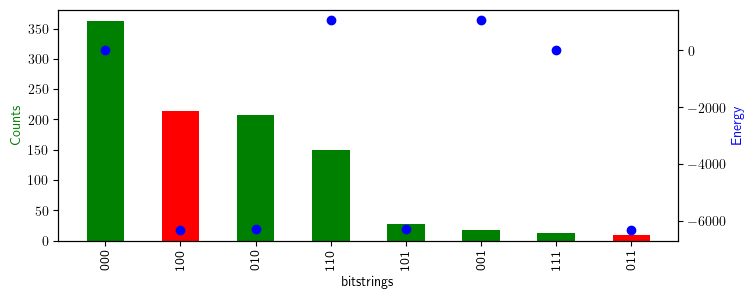

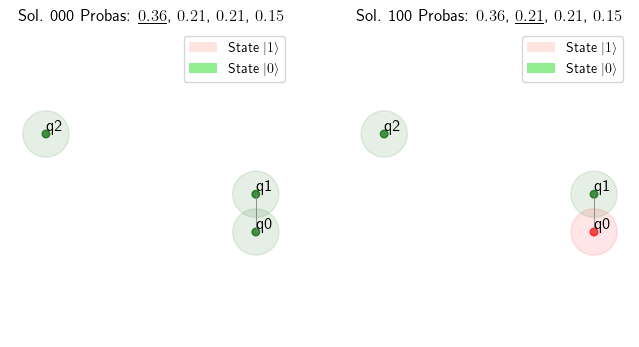

In [102]:
# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 2000
print("Q original:")
matprint(Q)
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=False)
Q_embedded = get_Q_from_coords(coords, device=DigitalAnalogDevice)
print("Scaled QUBO matrix Q:")
matprint(Q / normalization)
print("QUBO matrix Q embedded in register coordinates:")
matprint(Q_embedded)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
solutions = solve_qubo_bruteforce(Q, 2)

reg = Register(qubits)
Omega = 5.0
delta_i = -1.0
delta_f = -delta_i
T = 2_000  # time in ns
count_dict = anneal(reg, Omega, delta_i, delta_f, T)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:5]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True)

In [23]:
def arr_to_str(arr):
    """ [1, 0, 0 ] --> "100" """
    return ''.join(map(str, arr))

def str_to_arr(str):
    """ "100" --> [1, 0, 0] """
    return np.array([int(i) for i in str])

def evaluate_embedding_annealing_(Q, normalization:float=1000, lossf:str="mae", T:int=5_000, Omega=0.3, delta_i = -1.0, delta_f = 1.0, seed=4):
    # divide Q by a value to not have atoms touch (in Rydberg blockade)
    # does not change the solution
    coords, res = get_register_embedding(Q/normalization, seed=seed, lossf=lossf, device=DigitalAnalogDevice, ignore_warnings=True)
    Q_embedded = get_Q_from_coords(coords, device=DigitalAnalogDevice)
    qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
    solutions = solve_qubo_bruteforce(Q, 2)

    reg = Register(qubits)
    count_dict = anneal(reg, Omega, delta_i, delta_f, T)

    degenerate_solutions = []
    s0 = solutions[0][0]
    s0_energy = solutions[0][1]
    degenerate_solutions.append(s0)
    for s in solutions[1:]:
        if np.isclose(s[1], s0_energy, atol=1e-6):
            degenerate_solutions.append(s[0])

    pred1 = str_to_arr(count_dict.most_common(1)[0][0])
    pred2 = str_to_arr(count_dict.most_common(2)[1][0])
    out1 = [check_correct(pred1, ds) for ds in degenerate_solutions]
    out1 = np.any(out1)
    out2 = [check_correct(pred2, ds) for ds in degenerate_solutions]
    out2 = np.any(out2)
    out_dict = {
        "degenerate_solutions": degenerate_solutions,
        "count_dict": count_dict,
    }
    return (out1, out2), out_dict

def evaluate_embedding_annealing(n, normalization=1000, lossf:str="mae", T:int=5_000, Omega=0.3, delta_i = -1.0, delta_f = 1.0, seed=43, verbose:bool = False):
    g = np.random.default_rng(seed)
    time_sum = 120.0

    out1_list = []
    out2_list = []

    for i in tqdm(range(n), disable=not verbose):
        e12 = generate_double_u1_u2_MCP(
            time_sum=time_sum,
            bin_max=255,
            binsize=0.8,
            noise_std=1.0,
            g=g,
        )
        perms = g.integers(0, 2, size=3)
        for i in range(3):
            if perms[i] == 1:
                e12[i] = e12[i, ::-1]

        Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
        q = sols[0][0]
        out, count_dict = evaluate_embedding_annealing_(Q, normalization=normalization, seed=4, lossf=lossf, T=T)
        out1_list.append(out[0])
        out2_list.append(out[1])

    out1_list = np.array(out1_list)
    out2_list = np.array(out2_list)

    return np.sum(out1_list) / len(out1_list), np.sum(out2_list) / len(out2_list), np.sum(out1_list | out2_list) / len(out1_list)

    # print("percentage of correct solutions for most common:", np.sum(out1_list) / len(out1_list))
    # print("percentage of correct solutions for second most common:", np.sum(out2_list) / len(out2_list))
    # print("Either most or second most common correct:", np.sum(out1_list | out2_list) / len(out1_list))

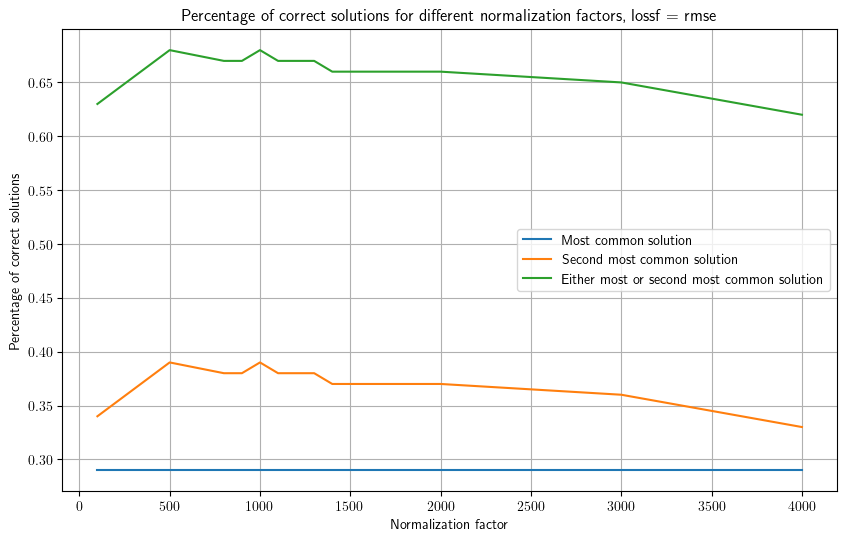

In [ ]:
most_common_corr_list = []
second_most_common_corr_list = []
either_corr_list = []
n = 100
lossf = "rmse"
T = 5_000 # ns
normalizations = [100, 500, 800, 900, 1000, 1100, 1200, 1300, 1400, 2000, 3000, 4000]
for normalization in normalizations:
    most_common, second_most_common, either = evaluate_embedding_annealing(n, seed=43, normalization=normalization, verbose=True, lossf=lossf, T=T)
    # print("percentage of correct solutions for most common:", most_common)
    # print("percentage of correct solutions for second most common:", second_most_common)
    # print("Either most or second most common correct:", either)
    most_common_corr_list.append(most_common)
    second_most_common_corr_list.append(second_most_common)
    either_corr_list.append(either)

most_common_corr_list = np.array(most_common_corr_list)
second_most_common_corr_list = np.array(second_most_common_corr_list)
either_corr_list = np.array(either_corr_list)

plt.figure(figsize=(10, 6))
plt.plot(normalizations, most_common_corr_list, label="Most common solution")
plt.plot(normalizations, second_most_common_corr_list, label="Second most common solution")
plt.plot(normalizations, either_corr_list, label="Either most or second most common solution")
plt.xlabel("Normalization factor")
plt.ylabel("Percentage of correct solutions")
plt.title(f"Percentage of correct solutions for different normalization factors, lossf = {lossf}")
plt.legend()
plt.grid()
plt.show()

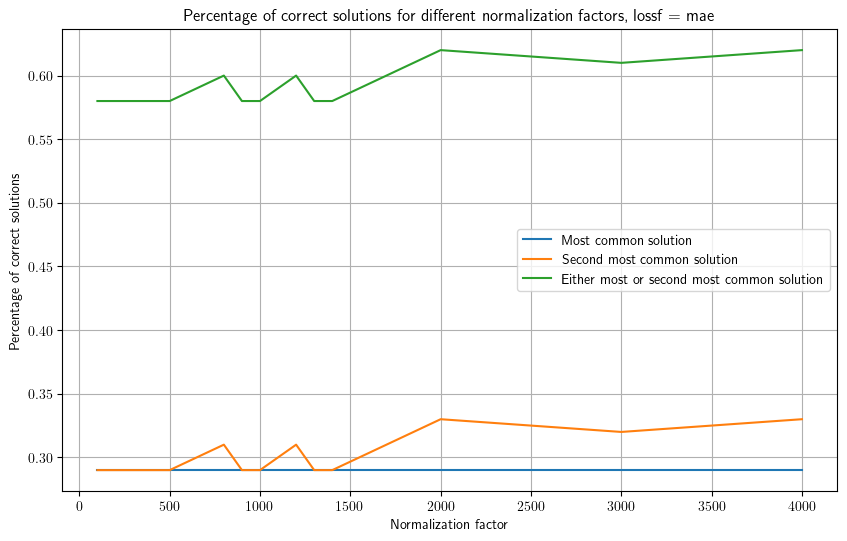

In [ ]:
most_common_corr_list = []
second_most_common_corr_list = []
either_corr_list = []
n = 100
lossf = "mae"
T = 5_000 # ns
normalizations = [100, 500, 800, 900, 1000, 1100, 1200, 1300, 1400, 2000, 3000, 4000]
for normalization in normalizations:
    most_common, second_most_common, either = evaluate_embedding_annealing(n, seed=43, normalization=normalization, verbose=True, lossf=lossf, T=T)
    # print("percentage of correct solutions for most common:", most_common)
    # print("percentage of correct solutions for second most common:", second_most_common)
    # print("Either most or second most common correct:", either)
    most_common_corr_list.append(most_common)
    second_most_common_corr_list.append(second_most_common)
    either_corr_list.append(either)

most_common_corr_list = np.array(most_common_corr_list)
second_most_common_corr_list = np.array(second_most_common_corr_list)
either_corr_list = np.array(either_corr_list)

plt.figure(figsize=(10, 6))
plt.plot(normalizations, most_common_corr_list, label="Most common solution")
plt.plot(normalizations, second_most_common_corr_list, label="Second most common solution")
plt.plot(normalizations, either_corr_list, label="Either most or second most common solution")
plt.xlabel("Normalization factor")
plt.ylabel("Percentage of correct solutions")
plt.title(f"Percentage of correct solutions for different normalization factors, lossf = {lossf}")
plt.legend()
plt.grid()
plt.show()

# ToDo
- add local detuning to get diagonal elements correct

Scaled QUBO matrix Q:
$$ Q_\text{scaled} = 
\begin{pmatrix}
-12.6238 & 13.6447 &-1.02096   \\
 13.6447 &-12.5373 &-1.10743   \\
-1.02096 &-1.10743 & 2.12838  
\end{pmatrix}
$$

QUBO matrix Q embedded in register coordinates:
$$ Q_\text{embedded} = 
\begin{pmatrix}
          0 &    13.6447 &6.29487e-05  \\
    13.6447 &          0 &8.47199e-05  \\
6.29487e-05 &8.47199e-05 &          0  
\end{pmatrix}
$$